In [24]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

### Loading Both Nino3.4 Time Series (https://psl.noaa.gov/data/timeseries/month/DS/Nino34/) and SSTs (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html)

In [15]:
# nino3.4 time series 
nino34 = '/home/tquresh/clim680/nino34.long.anom.nc'
nino34 = xr.open_dataset(nino34)
nino34

<xarray.Dataset> Size: 22kB
Dimensions:  (time: 1867)
Coordinates:
  * time     (time) datetime64[ns] 15kB 1870-01-01 1870-02-01 ... 2025-07-01
Data variables:
    value    (time) float32 7kB ...

In [16]:
# sst dataset, used from class
sst = '/home/lortizur/clim680/OISSTv2/monthly/sst.mnmean.nc'
sst = xr.open_dataset(file)
sst

<xarray.Dataset> Size: 120MB
Dimensions:    (time: 461, lat: 180, lon: 360, nbnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1981-12-01 1982-01-01 ... 2020-04-01
  * lat        (lat) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 119MB ...
    time_bnds  (time, nbnds) datetime64[ns] 7kB ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

In [21]:
# groupby djf for each year for el nino time series 

nino34_winter = nino34.copy()
nino34_winter['winter_year'] = (nino34['time'] + np.timedelta64(31, 'D')).dt.year # this shifts december so we count dec for its upcoming year
nino34_djf = nino34_winter.where(nino34['time'].dt.month.isin([12, 1, 2]), drop=True)
nino34_djf_mean = nino34_djf.groupby('winter_year').mean('time') # seasonal averages
nino34_djf_mean = nino34_djf_mean.sel(winter_year=slice(1871, 2025)) # make sure to consider years with full DJFs, we start jan 1870 so winter starts at 1871
nino34_djf_mean = nino34_djf_mean['value'] # each year represents a djf average

/home/tquresh/miniforge/envs/clim680/lib/python3.12/site-packages/xarray/structure/concat.py:637: UserWarning: No index created for dimension winter_year because variable winter_year is not a coordinate. To create an index for winter_year, please first call `.set_coords('winter_year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [22]:
# get MAM sst temperature anomalies for each grid point

sst_mam = sst.where(sst['time'].dt.month.isin([3, 4, 5]), drop=True)
sst_mam_mean = sst_mam.groupby('time.year').mean('time')
sst_mam_clim = sst_mam_mean.mean('year')
sst_mam_anom = sst_mam_mean - sst_mam_clim
sst_mam_anom = sst_mam_anom['sst']

In [23]:
# apply lag correlation. here, I noticed chatgpt said to shift the DJF years by one, but this did not make sense - when I asked it agian, it shifted its answer and aligned the years as is since the DJF has the same year as the following spring.

# use the same year coordinate name
nino = nino34_djf_mean.rename({'winter_year': 'year'})

common_years = np.intersect1d(nino['year'], sst_mam_anom['year'])
nino_sel = nino.sel(year=common_years)
sst_sel = sst_mam_anom.sel(year=common_years)

# Correlation (DJF → MAM of the same calendar year)
corr = xr.corr(sst_sel, nino_sel, dim='year')

corr

<xarray.DataArray (lat: 180, lon: 360)> Size: 259kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.14634152, -0.14125194, -0.14737415, ..., -0.13448088,
        -0.13448088, -0.13453598],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

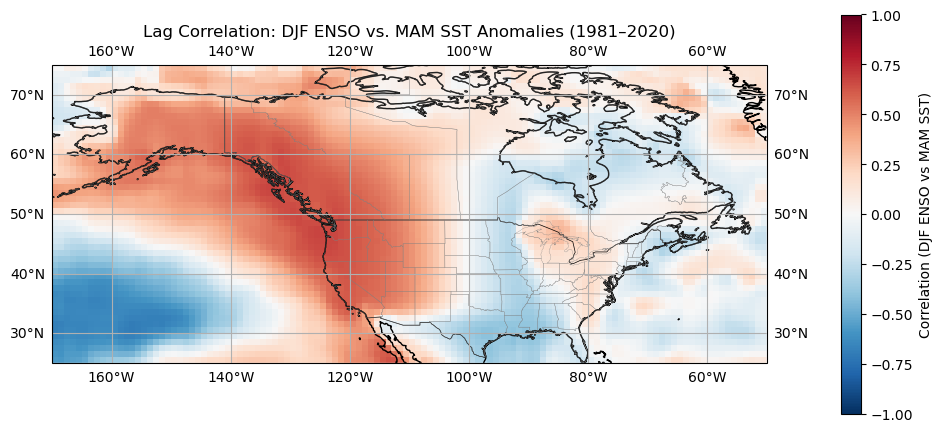

In [38]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# plotting correlation
correlation_plot = corr.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    cbar_kwargs={'label': 'Correlation (DJF ENSO vs MAM SST)', 
    'pad': 0.08, 
    'shrink': 0.7}
)


ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.2, edgecolor='gray')
ax.gridlines(draw_labels=True, linestyle='-')


ax.set_extent([-170, -50, 25, 75], crs=ccrs.PlateCarree())

ax.set_title('Lag Correlation: DJF ENSO vs. MAM SST Anomalies (1981–2020)', fontsize=12)
plt.tight_layout()
plt.show()

# Code and Scientific Critique

## 1. How effective was the AI? What code did it get right, and what did it get wrong (e.g., data alignment, pandas/xarray mixing)?
    I felt that the AI was more effective than I would think, because it generally was following my prompts and the answers were aligned with the details that I was providing it.
    While it used an interesting approach of breaking the seasonal averages into months rather than using time.season or other groupby methods that we have seen, the method seemed generally correct and straightforward. I think it did a good job at making copies if we were changing names or finding averages to make sure the original datasets were not altered. 
    I did not run into any errors with the xarray/pandas mixing, but one of the main issues I noticed immediately was data alignment. As you can see in my conversation with the AI, it tried to shift MAM anomalies back one year to align with the winter coming AFTER, but this did not make sense based on how it defined DJF since we shifted December and made sure that the winter year technically aligned with JF year. So, there would be no reason to shift because our MAM comes after our winter year when the year is the same, which is what we want to see in terms of spring temperatures following winter ENSO.
    I actually found it plotted projections and statelines and coastlines well without any prompting.
    
## 2. Look at your final correlation map. What pattern do you see?
    I notice that there is not a homogenous lag relationship in the contintential United States, nor the Pacific or Atlantic oceans. 
     It seems that the Northwestern part of the United States has a positive lag relationship, meaning increases in the Nino3.4 index (warmer central/eastern Pacific waters) in the winter do correlate to warmer temperatures in the Northwestern US.
     This positive relationship is seen in the northern Pacific ocean region (from Alaska down the California coast) as well. 
     In opposition, it seems that there is more of a negative lag correlation in the midwestern/central Southern region of the United States, implying that warmer 3.4 indices would cool this region of the US or cooler 3.4 indices would warm it, etc. 
     There is a smaller positive correlation in the eastern part of the United States and some splotches of low positive/negative corelations throughout this area, but generally the Western US is much more strongly correlated both positively and negatively in terms of how spring temperatures are influenced by the previous ENSO winter.
    
## 3. What is a major limitation of this simple analysis? (e.g., What did we not test for?)
    We did not test for precipitation, which is also an important aspect of the ENSO variability, nor lag relationships for other seasons. For example, there is significant JJA buildup of warm temperatures preceding a strong DJF ENSO year.  

## 4. What is your main takeaway about using AI for this kind of task?
    It's surprising that the AI can generally do the job well (especially in terms of improving plots/direct calculations), but it is important to recognize that it fully will say a method that is incorrect and go with it.
    Therefore, if you don't know or fully understand its method, it can easily give you the wrong interpretation or method that seems "right". It will also try to pull its own methods or how its trained, but updated methods from current researchers/forums that have information on how scientists can often times be more efficient and easier to understand.


## My AI log, in which I used ChatGPT: https://chatgpt.com/share/68f79f58-b8a8-8002-844b-1af36128962e